# Explore difference-image objects in the Galactic fields

This notebook was created Wed June 21 for Duncan Wood.

```
Name         RA         Dec        RA (deg)   Dec (deg)
DECaPS-East  18:03:34   −29:32:02  270.89167  -29.53389
DECaPS-West  07:45:16.8 −26:15:00  116.32     -26.25
```

In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from astropy.coordinates import SkyCoord

import getpass
import psycopg2
import psycopg2.extras

Excute the cell and be prompted for username and password.

For the password it will suggest to you your NERSC password (I think), so you have to first delete that and then enter the database password. If your browser gives you the pop-up asking if you want to "Update password?", don't do it.

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  decat_ro
DB Password:  ········


In [6]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")
db.autocommit = True
cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

If you want to print out the schema for the available tables.

In [7]:
# tables = ['exposures', 'subtractions', 'objects', 'candidates', 'versiontags']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

Set the version of the tag to use. 

> **This is something to be checked with Rob Knop.**

In [8]:
tag = "latest"
db.rollback()
q = ( "SELECT id, tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']
print(tagid)

1


Get all objects in the DECaPS fields by constraining RA and Dec. This takes about a minute.

In [9]:
%%time
q = ("SELECT od.ra, od.dec, od.mag, od.magerr, rbs.rb, "
     "i.filter, i.meanmjd, o.candidate_id, e.proposalid "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt "
     "ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE ((od.ra > 267.8 AND od.ra < 273.8 AND od.dec > -32.5 AND od.dec < -26.5) "
     "OR (od.ra > 113.3 AND od.ra < 119.3 AND od.dec > -29.3 AND od.dec < -23.3)) ")
cursor.execute(q, {'tagid': tagid})
df = pandas.DataFrame(cursor.fetchall())
print(len(df))

3728632
CPU times: user 23.6 s, sys: 2.32 s, total: 25.9 s
Wall time: 49 s


Convert the returned data into numpy arrays (Melissa's preference; use whatever you like).

```
ra      =  right ascension (decimal degrees)
dec     =  declination (decimal degrees)
mag     =  apparent magnitude from difference-image flux
mage    =  error in apparent magnitude from difference-image flux
rb      =  real/bogus score (0 to 1, bogus to real)
filt    =  filter, griz
mjd     =  modified julian date
candid  =  candidate id
propid  =  proposal id
```

In [10]:
raw_obj_ra     = np.asarray(df[0], dtype='float')
raw_obj_dec    = np.asarray(df[1], dtype='float')
raw_obj_mag    = np.asarray(df[2], dtype='float')
raw_obj_mage   = np.asarray(df[3], dtype='float')
raw_obj_rb     = np.asarray(df[4], dtype='float')
raw_obj_filt   = np.asarray(df[5], dtype='str')
raw_obj_mjd    = np.asarray(df[6], dtype='float')
raw_obj_candid = np.asarray(df[7], dtype='str')
raw_obj_propid = np.asarray(df[8], dtype='str')
del df

Make a few plots to explore the Galactic data.

<br><br>

Looks like there is only one field, DECaPS-East.

> **This is something else to be checked by Rob Knop.**

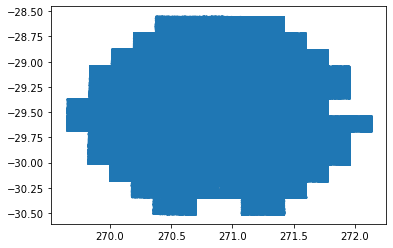

In [11]:
plt.plot(raw_obj_ra, raw_obj_dec, 'o', ms=2, alpha=0.2, mew=0)

<br>
Looks like there is only 2021 data available, but this might be a result of the choice of R/B tag.

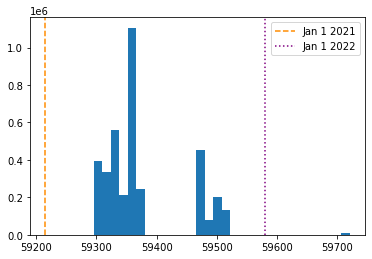

In [29]:
plt.hist(raw_obj_mjd, bins=30)
plt.axvline(59215.5, ls='dashed', color='darkorange', label='Jan 1 2021')
plt.axvline(59580.5, ls='dotted', color='purple', label='Jan 1 2022')
plt.legend(loc='best')
plt.show()

<br>
Looks like most of it is classified as bogus, but again, I'm not sure which of the R/B tags we should use here.

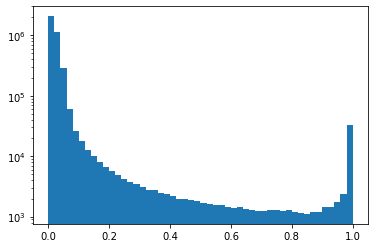

In [16]:
plt.hist(raw_obj_rb, bins=50, log=True)
plt.show()

<br>
How many unique candidates are there among the "good" (let's say R/B >= 0.8) objects?

Recall that one "object" is one detection in a difference-image, and one "candidate" is a set of objects at the same sky coordinate.

In [26]:
tx = np.where(raw_obj_rb >= 0.8)[0]
print('number of "good" (R/B>=0.8) objects: ', len(tx))

number of "good" (R/B>=0.8) objects:  46117


In [27]:
values, counts = np.unique(raw_obj_candid[tx], return_counts=True)
print('number of unique candidates for "good" objects: ', len(values))

number of unique candidates for "good" objects:  3767


<br> 
Plot the distribution of the number of objects per candidate. See that there are many candidates with just one detection. Those candidates & objects can be rejected from further study.

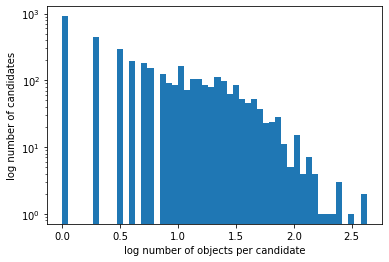

In [24]:
plt.hist(np.log10(counts), bins=50, log=True)
plt.xlabel('log number of objects per candidate')
plt.ylabel('log number of candidates')
plt.show()